# 01. Data Preprocessing & Knowledge Base Creation

In this notebook, we will:
1. Load the raw medical dataset.
2. Perform Exploratory Data Analysis (EDA) to understand the data distribution.
3. Clean and chunk the text to prepare it for the RAG system.
4. Save the processed knowledge base.

In [ ]:
# ==========================================
# 1. Global Setup & Imports
# ==========================================
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import configurations and visualization utilities
from src.config import RAW_DATA_PATH, PROCESSED_DATA_PATH, CHUNK_SIZE, CHUNK_OVERLAP
from src.visualization import set_plot_style, plot_distribution

# Set consistent style
set_plot_style()
%matplotlib inline

# Configuration
FORCE_PREPROCESSING = False

In [ ]:
# ==========================================
# 2. Load Data & Basic EDA
# ==========================================
# Load Data
df = pd.read_csv(RAW_DATA_PATH)
print(f"Dataset shape: {df.shape}")

# Basic Info
print("\n--- DataFrame Info ---")
df.info()

# Check for missing values
print("\n--- Missing Values ---")
print(df.isnull().sum())

# Display sample
df.head()

Dataset shape: (16407, 3)


,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


Plot saved to: ../output\answer_length_distribution.png


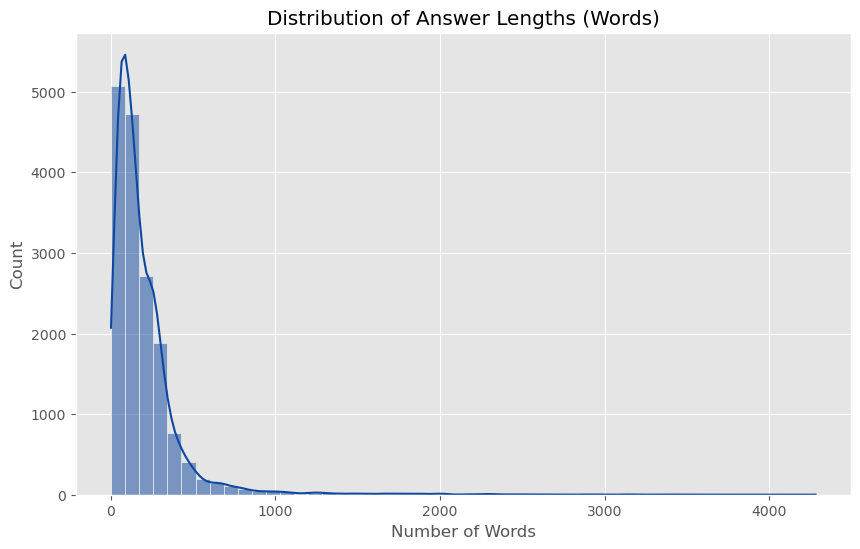

Mean length: 201.35
Max length: 4281
95th percentile: 523.00


In [ ]:
# ==========================================
# 3. Analyze Answer Lengths
# ==========================================
# Calculate approximate token count (splitting by space)
df['answer_length'] = df['Answer'].astype(str).apply(lambda x: len(x.split()))

# Statistics
print(f"Mean length: {df['answer_length'].mean():.2f} words")
print(f"Max length: {df['answer_length'].max()} words")
print(f"95th percentile: {df['answer_length'].quantile(0.95):.2f} words")

# Visualization
plot_distribution(
    df['answer_length'], 
    title='Distribution of Answer Lengths (Words)', 
    xlabel='Number of Words', 
    ylabel='Count',
    save_path='../output',
    filename='answer_length_distribution.png'
)

In [ ]:
# ==========================================
# 4. Chunking Logic
# ==========================================
def simple_chunker(text, chunk_size=CHUNK_SIZE, overlap=CHUNK_OVERLAP):
    """
    Splits text into chunks of specified size with overlap.
    """
    words = text.split()
    if len(words) <= chunk_size:
        return [text]
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = " ".join(words[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

# Check if we should skip
if not FORCE_PREPROCESSING and os.path.exists(PROCESSED_DATA_PATH):
    print(f"Found existing processed data at {PROCESSED_DATA_PATH}. Skipping preprocessing.")
    df_chunks = pd.read_parquet(PROCESSED_DATA_PATH)
else:
    # Apply chunking
    print("Chunking data...")
    chunks_data = []
    for idx, row in df.iterrows():
        answer = str(row['Answer'])
        question = str(row['Question'])
        qtype = str(row['qtype'])
        
        text_chunks = simple_chunker(answer)
        
        for i, chunk in enumerate(text_chunks):
            # Embed both question and answer for better retrieval context
            combined_text = f"Question: {question}\nAnswer: {chunk}"
            chunks_data.append({
                'original_id': idx,
                'qtype': qtype,
                'question': question,
                'chunk_id': f"{idx}_{i}",
                'text': combined_text, 
                'pure_answer_chunk': chunk,
                'full_answer': answer 
            })

    df_chunks = pd.DataFrame(chunks_data)
    print(f"Original rows: {len(df)}")
    print(f"Chunked rows: {len(df_chunks)}")
    df_chunks.head()

Original rows: 16407
Chunked rows: 17833


,original_id,qtype,question,chunk_id,text,pure_answer_chunk,full_answer
0,0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,0_0,Question: Who is at risk for Lymphocytic Chori...,LCMV infections can occur after exposure to fr...,LCMV infections can occur after exposure to fr...
1,1,symptoms,What are the symptoms of Lymphocytic Choriomen...,1_0,Question: What are the symptoms of Lymphocytic...,LCMV is most commonly recognized as causing ne...,LCMV is most commonly recognized as causing ne...
2,2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,2_0,Question: Who is at risk for Lymphocytic Chori...,Individuals of all ages who come into contact ...,Individuals of all ages who come into contact ...
3,3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,3_0,Question: How to diagnose Lymphocytic Choriome...,"During the first phase of the disease, the mos...","During the first phase of the disease, the mos..."
4,4,treatment,What are the treatments for Lymphocytic Chorio...,4_0,Question: What are the treatments for Lymphocy...,"Aseptic meningitis, encephalitis, or meningoen...","Aseptic meningitis, encephalitis, or meningoen..."


In [ ]:
# ==========================================
# 5. Export Knowledge Base
# ==========================================
# Save to Parquet file for efficient storage
if not os.path.exists(PROCESSED_DATA_PATH) or FORCE_PREPROCESSING:
    df_chunks.to_parquet(PROCESSED_DATA_PATH, index=False)
    print(f"Saved processed data to {PROCESSED_DATA_PATH}")
else:
    print(f"Data already exists at {PROCESSED_DATA_PATH}. Skipping save.")

Saved processed data to c:\Users\matteucc\Desktop\Portfolio_improvement\Medical_question_answering\data\knowledge_base.parquet
